In [89]:
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [90]:
data = data.reset_index('Date', inplace=False)

In [91]:
df = data

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [93]:
df1=df.reset_index()['Close']

In [94]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [95]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [96]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [97]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [98]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [99]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [100]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 16s 416ms/step - loss: 0.0805 - val_loss: 0.0094
Epoch 2/100
14/14 [==============================] - 4s 302ms/step - loss: 0.0120 - val_loss: 0.0181
Epoch 3/100
14/14 [==============================] - 4s 303ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 4/100
14/14 [==============================] - 4s 299ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 5/100
14/14 [==============================] - 4s 285ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 6/100
14/14 [==============================] - 2s 134ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 7/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/100
14/14 [==============================] - 2s 151ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/100
14/14 [==============================] - 2s 138ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 10/100
14/14 [==============================] - 3s 214ms/step - loss: 0.0018 - val_l

In [101]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 19ms/step


In [102]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [103]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [104]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 33.78127351744279
Testing RMSE: 20.07203666522156


In [105]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 30.346768188476602
Testing MAE: 15.813662771451272


In [106]:
from sklearn.metrics import mean_absolute_percentage_error

In [107]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 33.78127351744279
Testing MAPE: 20.07203666522156


In [109]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.8656461  0.87398601 0.86016221 0.85959098 0.85307898 0.86061922
 0.85867709 0.84553874 0.78453106 0.78830111 0.79458467 0.80109681
 0.78830111 0.78441684 0.77196394 0.77436309 0.75174222 0.7606535
 0.75882559 0.75037132 0.74922885 0.73323433 0.72272371 0.73209187
 0.74568724 0.75574085 0.75094255 0.7671655  0.76739408 0.72855025
 0.72717921 0.74614425 0.78350281 0.84028328 0.83399972 0.85730605
 0.84862334 0.90666063 0.9173997  0.87033018 0.88038393 0.9340798
 0.92071287 0.88678171 0.90963102 0.90243343 0.91865652 0.90574661
 0.92276937 0.96652571 0.96504059 0.9547584  0.92871013 0.94664692
 0.95361593 0.98834691 0.9436764  0.93453668 0.9496173  0.93567914
 0.94984574 0.91774249 0.92871013 0.93430824 0.92482572 0.92962416
 0.9298526  0.92219814 0.95750034 0.97383751 0.99600137 0.96104196
 0.97120993 0.98252022 0.97600823 0.95795722 0.95772878 0.96172741
 0.92791046 0.9191134  0.89146579 0.91682846 0.91237296 0.90963102
 0.89866338 0.87615673 0.87729919 0.89317949 0.89992

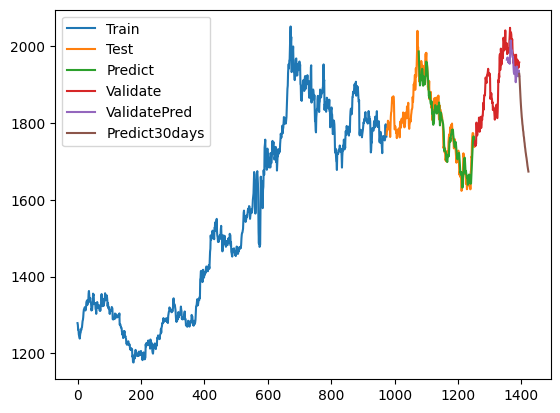

In [110]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [111]:
scaler.inverse_transform(lst_output)

array([[1928.19436488],
       [1917.59088589],
       [1899.80776422],
       [1883.1854684 ],
       [1866.36997986],
       [1851.63625641],
       [1838.43002326],
       [1827.27738235],
       [1815.9633736 ],
       [1808.02958539],
       [1797.57709203],
       [1791.73075566],
       [1781.48658488],
       [1776.87922794],
       [1766.90942945],
       [1762.44815396],
       [1753.03633445],
       [1747.43833655],
       [1738.50592508],
       [1733.00747126],
       [1725.2515894 ],
       [1719.91737287],
       [1713.53142203],
       [1708.78664418],
       [1702.26614188],
       [1695.95964892],
       [1688.81741352],
       [1683.52138686],
       [1678.01109   ],
       [1673.53186736]])